## DEEPTUNES!
Spotify Playlist Recommender 

*Padgett, Jacob*  
*Quinn, Avery*  
*Strauffer-Norris, Will*  

**GIT: https://github.com/Lambda-Spotify-Song-Suggester-3/datascience**  
**APP: https://deeptunes.now.sh/**

## Load Data

In [0]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from keras.layers import Input, Embedding, Flatten, Dot
from keras.models import Model
from sklearn.decomposition import PCA

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
%matplotlib inline

# Load Data
data = pd.read_csv("https://raw.githubusercontent.com/Lambda-Spotify-Song-Suggester-3/datascience/master/kaggle_data/encoded.csv")
df = data.copy()

In [0]:
print(df.shape)
data.sample(1)

(130663, 19)


,artist_name,track_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity,track_key,artist_key
42539,S-X,47lUlUSCV2oUcpI7qlKN5o,Stay,0.516,0.368,193622,0.488,0.000414,5,0.0924,-6.076,0,0.0378,87.011,4,0.156,36,42528,9996


## Neural Network

In [0]:
# Truncate dataframe
df = df[:10000]
# Drop non-numeric columns
df = df.drop(columns=['artist_name','track_id', 'track_name'])

# Train / Test Split
train, test = train_test_split(df, test_size=0.2, random_state=42)

# Features / Target
X_train = train.drop(columns='popularity')
y_train = train['popularity']
X_test = test.drop(columns='popularity')
y_test= test['popularity']

# Unique Number of artist and songs
n_artists = len(df['artist_key'].unique())
n_songs = len(df['track_key'].unique())
print("artists:",n_artists)
print("songs:", n_songs)

artists: 3770
songs: 9989


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Epoch 1/200
 - 1s - loss: 1033.8552
Epoch 2/200
 - 1s - loss: 1033.7156
Epoch 3/200
 - 1s - loss: 1033.4073
Epoch 4/200
 - 1s - loss: 1032.7474
Epoch 5/200
 - 1s - loss: 1031.5786
Epoch 6/200
 - 1s - loss: 1029.8297
Epoch 7/200
 - 1s - loss: 1027.5070
Epoch 8/200
 - 1s - loss: 1024.6451
Epoch 9/200
 - 1s - loss: 1021.2979
Epoch 10/200
 - 1s - loss: 1017.5172
Epoch 11/200
 - 1s - loss: 1013.3383
Epoch 12/200
 - 1s - loss: 1008.8018
Epoch 13/200
 - 1s - loss: 1003.9294
Epoch 14/200
 - 1s - loss: 998.7514
Epoch 15/200
 - 1s - loss: 993.2979
Epoch 16/200
 - 1s - loss: 987.5703
Epoch 17/200
 - 1s - loss: 981.5887
Epoch 18/200
 - 1s - loss: 975.3727
Epoch 19/200
 - 1s - loss: 968.9314
Epoch 20/200
 - 1s - loss: 962.2718
Epoch 21/200
 - 1s - loss: 955.4003
Epoch 22/200
 - 1s - loss: 948.3317
Epoch 23/200
 - 1s - loss: 941.0663
Epoch 24/200
 - 1s - loss: 933.6213
Epoch 25/200
 - 1s - loss: 925.9995
Epoch 26/200
 - 1s - loss: 918.2077
Epoch 27/200
 - 1s - loss: 910.2492
Epoch 28/200
 - 1s - los

Text(0, 0.5, 'Training Error')

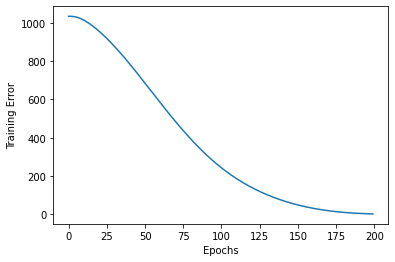

In [0]:
# Neural Network Model 

# Model Layers 
#=> Embedding Artists
artist_input = Input(shape=[1], name="Artist-Input")
artist_embedding = Embedding(n_artists+1, 5, name="Artist-Embedding")(artist_input)
artist_vec = Flatten(name="Flatten-Artist")(artist_embedding)

#=> Embedding Song
song_input = Input(shape=[1], name="Song-Input")
song_embedding = Embedding(n_songs+1, 5, name="Song-Embedding")(song_input)
song_vec = Flatten(name="Flatten-Song")(song_embedding)

# Model
prod = Dot(name="Dot-Product", axes=1)([artist_vec, song_vec])
model = Model([artist_input, song_input], prod)

# Compile Model
model.compile('adam', 'mean_squared_error')

# Fit Model
history = model.fit([train.artist_key, train.track_key], train.popularity, epochs=200, verbose=2)
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Error")

In [0]:
# Evaluate
model.evaluate([test.artist_key, test.track_key], test.popularity)
# Predict
predictions = model.predict([test.artist_key.head(5), test.track_key.head(5)])
[print(predictions[i], test.popularity.iloc[i]) for i in range(0,5)]

# Extract embeddings
song_em = model.get_layer('Song-Embedding')
song_em_weights = song_em.get_weights()[0]

2000/2000 [==============================] - 0s 43us/step
[-0.54296184] 38
[-0.00074168] 43
[0.19359007] 24
[-0.03520726] 0
[0.15883607] 21


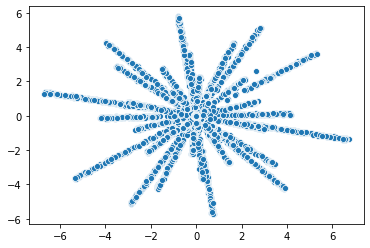

In [0]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(song_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [0]:
#=> Making recommendation

# array of encoded songs
song_data = np.array(list(df.track_key))

# Test Song:(404) Maroon 5 "Girls Like You"
artist = np.array([404 for i in range(len(song_data))])

# Predictions
predictions = model.predict([artist, song_data])
predictions = np.array([a[0] for a in predictions])
recommended_song_ids = (-predictions).argsort()[:10]
print("Songs:", recommended_song_ids)
print("Predictions:", predictions[recommended_song_ids])

# Returns dataframe of tens predicted songs ordered by index value
#data[data["track_key"].isin(recommended_song_ids)]

Songs: [9941 9897 7391  523 9348 3620  188 3629  189 9803]
Predictions: [42.668606 42.302185 42.204712 42.079525 42.053787 42.037502 41.89334
 41.74872  41.71405  41.57731 ]


In [0]:
#=> HOW TO SAVE AND LOAD MODEL
#model.save("model.h5")
#print("Saved model to disk")

#=> IMPORT
#from keras.models import load_model

#=> LOAD MODEL
#model = load_model('model.h5')

#=> SUMMARIZE MODEL
#model.summary()

In [0]:
# Helper Functions
def epic_predictor(input_track_key):
  '''
  This function takes in a 'track_key' and returns a list of ten numbers 
  that are the "track_key"s of the dataframe imported above.
  '''
  song_data = np.array(list(df.track_key))
  artist = np.array([input_track_key for i in range(len(song_data))])

  predictions = model.predict([artist, song_data])
  predictions = np.array([a[0] for a in predictions])
  recommended_song_ids = (-predictions).argsort()[:10]

  ten_similar_tracks = df[df["track_key"].isin(recommended_song_ids)]
  
  return ten_similar_tracks['track_key'].tolist()

def feature_average(input_track_key):
  '''
  This function returns the average of the features for the ten recommended songs.
  '''
  song_data = np.array(list(df.track_key))
  artist = np.array([input_track_key for i in range(len(song_data))])

  predictions = model.predict([artist, song_data])
  predictions = np.array([a[0] for a in predictions])
  recommended_song_ids = (-predictions).argsort()[:10]

  # Return a dataframe with only the ten most similar tracks
  ten_similar_tracks = df[df["track_key"].isin(recommended_song_ids)]
  ten_similar_tracks = ten_similar_tracks[['acousticness', 'danceability', 
                                           'energy', 'instrumentalness', 
                                           'liveness', 'mode', 
                                           'speechiness', 'valence']]

  # Average features of ten tracks                                           
  acousticness = round(ten_similar_tracks['acousticness'].mean(),2)
  danceability = round(ten_similar_tracks['danceability'].mean(),2)
  energy = round(ten_similar_tracks['energy'].mean(),2)
  instrumentalness = round(ten_similar_tracks['instrumentalness'].mean(),2)
  liveness = round(ten_similar_tracks['liveness'].mean(),2)
  mode = round(ten_similar_tracks['mode'].mean(),2)
  speechiness = round(ten_similar_tracks['speechiness'].mean(),2)
  valence = round(ten_similar_tracks['valence'].mean(),2)
  
  # Store all to "features" variable
  features = acousticness, danceability, energy, instrumentalness, liveness, mode, speechiness, valence
  
  return features

In [0]:
# Testing
print("Predicted Songs:", epic_predictor(404))
features = feature_average(404)
print("--------------------")
print("Averages:")
print("acousticness", features[0])
print("danceability", features[1])
print("energy", features[2])
print("instrumentalness", features[3])
print("liveness", features[4])
print("mode", features[5])
print("speechiness", features[6])
print("valence", features[7])

Predicted Songs: [188, 189, 523, 3620, 3629, 7391, 9348, 9803, 9897, 9941]
--------------------
Averages:
acousticness 0.35
danceability 0.56
energy 0.59
instrumentalness 0.11
liveness 0.17
mode 0.6
speechiness 0.12
valence 0.35


# Cosine Simiarity Model

In [0]:
df = data.copy()
dictionary = df[["artist_name", "track_name", "track_key"]]
df = df.drop(columns=['artist_name','track_id', 'track_name','track_key'])

# Scale data
scaler = MinMaxScaler()
df_s = scaler.fit_transform(df)

In [0]:
data.iloc[622][0:3]

artist_name                                       Maroon 5
track_id                            2Fs5Tk06RWbDIBOPtOxTUD
track_name     Girls Like You (feat. Cardi B) - CRAY Remix
Name: 622, dtype: object

In [0]:
# Cosign Similarity
# song by index value
matrix = cosine_similarity(df_s, df_s[622:623] )
matrix = pd.DataFrame(matrix)
#matrix #shape(130663, 1)


In [0]:
matrix[0].sort_values(ascending=False)[:5]
#matrix[matrix[0] < 1][0].sort_values(ascending=False)[:5]

622       1.000000
114004    0.997176
620       0.997137
94021     0.996651
85183     0.996319
Name: 0, dtype: float64

In [0]:
top3 = matrix[matrix[0] < 1][0].sort_values(ascending=False)[:3]
top3
# Print Playlist
z = top3.reset_index()
for col in z["index"]:
  print(dictionary.iloc[col])
  print("---------")

artist_name                      Kiiara
track_name     I Don't Wanna Be Friends
track_key                        113917
Name: 114004, dtype: object
---------
artist_name    Jevon
track_name     Judas
track_key        621
Name: 620, dtype: object
---------
artist_name                                        24hrs
track_name     NEW GUY (feat. Rossi Rock, Casey Veggies)
track_key                                          94005
Name: 94021, dtype: object
---------


In [0]:
def epic_predictor(input_track_key):
  '''
  This function takes in a 'track_key' which is a number from 0 to 130,000 something.
  The function returns a list of three numbers that are the "track_key"s of the
  dataframe imported above.
  '''
# Cosign Similarity
  matrix = cosine_similarity(df_s, df_s[input_track_key:(input_track_key + 1)])
  
  matrix = cosine_similarity(df_s, df_s[622:623] )
  matrix = pd.DataFrame(matrix)
  top3 = matrix[matrix[0] < 1][0].sort_values(ascending=False)[:3]
  # Print Playlist
  z = top3.reset_index()
  three_similar_tracks = []

  for col in z["index"]:
    track = (dictionary['track_key'].iloc[col])
    three_similar_tracks.append(track)

  return three_similar_tracks


def feature_average(input_track_key):
  '''
  This function returns the average of the features for the ten recommended songs.
  '''
  three_similar_tracks = epic_predictor(input_track_key)
  # Return a dataframe with only the ten most similar tracks
  three_similar_tracks = data[data["track_key"].isin(three_similar_tracks)]
  three_similar_tracks = three_similar_tracks[['acousticness', 'danceability', 
                                           'energy', 'instrumentalness', 
                                           'liveness', 'mode', 
                                           'speechiness', 'valence']]
  # Average features of ten tracks                                           
  acousticness = round(three_similar_tracks['acousticness'].mean(),2)
  danceability = round(three_similar_tracks['danceability'].mean(),2)
  energy = round(three_similar_tracks['energy'].mean(),2)
  instrumentalness = round(three_similar_tracks['instrumentalness'].mean(),2)
  liveness = round(three_similar_tracks['liveness'].mean(),2)
  mode = round(three_similar_tracks['mode'].mean(),2)
  speechiness = round(three_similar_tracks['speechiness'].mean(),2)
  valence = round(three_similar_tracks['valence'].mean(),2)
  # Store all to "features" variable
  features = []
  attributes = [acousticness, danceability, energy, instrumentalness, liveness, mode, speechiness, valence]
  #features.append(acousticness)
  for attribute in attributes:
    features.append(attribute)
  return features

In [0]:
# Test
print("Predicted Song Track_keys:", epic_predictor(622))
print("Average Features:", feature_average(622))

Predicted Song Track_keys: [113917, 621, 94005]
Average Features: [0.18, 0.83, 0.65, 0.0, 0.11, 0.0, 0.07, 0.39]


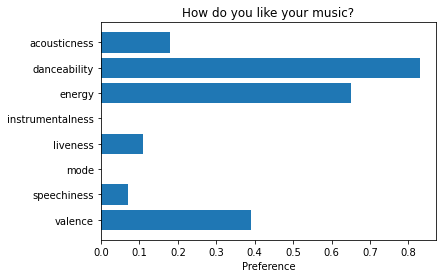

In [0]:
# Simple Bar Chart
fig, ax = plt.subplots()
# data
features = ('acousticness', 'danceability', 'energy', 'instrumentalness',
          'liveness', 'mode','speechiness', 'valence')
y_pos = np.arange(len(features))
performance = feature_average(622)
ax.barh(y_pos, performance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(features)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Preference')
ax.set_title('How do you like your music?')
plt.show()

# Nearest Neighbor Model

In [0]:
df = data.copy()
dictionary = df[["artist_name", "track_name", "track_key", "track_id"]]
# Drop
df = df.drop(columns=['artist_name','track_id', 'track_name','track_key', 'duration_ms', 'mode', 'loudness', 'time_signature'])

# Scale the data
scaler = StandardScaler()
df_s = scaler.fit_transform(df)

In [0]:
def epic_predictor(input_track_key):
  '''
  This function takes in a 'track_key' of a song in the dataframe imported
  above, which is a number from 0 to 130,000 something.

  The function returns a list of ten hashes that are the "track_id"s of most
  closely related songs in the dataframe imported above.
  -------
  For example, your function will look like this for Britney Spears' "Toxic":
  > input:
  toxic_track_key = 119347
  epic_predictor(toxic_track_key) 
  >output:
  >>>['4fbaKWFRghusXd4bSBvvfN',
  >>>'5cesclKWAhsCcZJDBhkWaa',
  >>> '7IE8eERSpTC9Jaw3arl99B',
  >>> '6MLvUL2dYphJTwgiBvuJ1J',
  >>> '4RYtaqxjDJUOY2GrtkLTFf',
  >>> '6gJ1T7THE0Pxk5VpTovwJH',
  >>> '7hiFcSUWRVotWd2pxhRIDJ',
  >>> '6flP4UZGozZGQk8rpE09g4',
  >>> '4uLmKWOb8hl49MYYAc4bnn',
  >>> '39Z6LCw3UEFYjQivDV1UF1']

  '''
  ## Convert "input_track_key" to the index of the song (the song's position
  ## in the dataframe).
  input_dictionary_entry = dictionary[dictionary['track_key']==input_track_key]
  input_index = input_dictionary_entry.index[0]

  ## Nearest Neighbors model
  nn = NearestNeighbors(n_neighbors=10, algorithm='kd_tree')
  nn.fit(df_s)

  neighbor_predictions = nn.kneighbors([df_s[input_index]])

  ## This is a list of the INDEXES of the songs
  list_of_predictions = neighbor_predictions[1][0].tolist()

  ten_similar_tracks = []
  for item in list_of_predictions:
    track_hash = dictionary['track_id'].iloc[item]
    ten_similar_tracks.append(track_hash)

  return ten_similar_tracks

##################################################################

def feature_average(input_track_key):
  '''
  This function returns the average of the features for the ten recommended songs.
  '''
  ten_similar_tracks = epic_predictor(input_track_key)
  # Return a dataframe with only the ten most similar tracks
  ten_similar_tracks = data[data["track_id"].isin(ten_similar_tracks)]
  ten_similar_tracks = ten_similar_tracks[['acousticness', 'danceability', 
                                           'energy', 'instrumentalness', 
                                           'liveness', 'mode', 
                                           'speechiness', 'valence']]
  # Average features of ten tracks                                           
  acousticness = round(ten_similar_tracks['acousticness'].mean(),2)
  danceability = round(ten_similar_tracks['danceability'].mean(),2)
  energy = round(ten_similar_tracks['energy'].mean(),2)
  instrumentalness = round(ten_similar_tracks['instrumentalness'].mean(),2)
  liveness = round(ten_similar_tracks['liveness'].mean(),2)
  mode = round(ten_similar_tracks['mode'].mean(),2)
  speechiness = round(ten_similar_tracks['speechiness'].mean(),2)
  valence = round(ten_similar_tracks['valence'].mean(),2)
  # Store all to "features" variable
  features = []
  attributes = [acousticness, danceability, energy, instrumentalness, liveness, mode, speechiness, valence]
  #features.append(acousticness)
  for attribute in attributes:
    features.append(attribute)
  return features 

In [0]:
# Testing
track_key = 622
print(epic_predictor(track_key))
print(feature_average(track_key))

['3mvYQKm8h6M5K5h0nVPY9S', '3mvYQKm8h6M5K5h0nVPY9S', '2bSk87AVkCIIC3Bcligq1z', '7MjaU5iFujwT1gOyvJnqNp', '14FwKi5Lh5HRXeo6VNXlaN', '1ry2SRTPT0w0FvdRtvr64K', '2gXOzCwbVXACCaYRj4Qrep', '3nYGWwvtwNM5OKR3meujcm', '40wyhIkaVvuZUAbAiTOkHI', '5GsDw8rD0LJ9XF4dEzUPDK']
[0.07, 0.73, 0.49, 0.0, 0.12, 0.7, 0.18, 0.3]


In [0]:
## You can use this to print out the artist name and track name of the list of hashes generated.
print(dictionary[dictionary['track_id']=='3mvYQKm8h6M5K5h0nVPY9S'])
print(dictionary[dictionary['track_id']=='2bSk87AVkCIIC3Bcligq1z'])

       artist_name  ...                track_id
621          Drake  ...  3mvYQKm8h6M5K5h0nVPY9S
124538       Drake  ...  3mvYQKm8h6M5K5h0nVPY9S

[2 rows x 4 columns]
       artist_name    track_name  track_key                track_id
119106    Lil Baby  Life Goes On     118969  2bSk87AVkCIIC3Bcligq1z


In [0]:
features_df = pd.DataFrame(dict(
    r=feature_average(track_key),
    theta=['acousticness', 'danceability', 'energy', 'instrumentalness',
          'liveness', 'mode','speechiness', 'valence']))
fig = px.line_polar(features_df, r='r', theta='theta', line_close=True)
fig.update_traces(fill='toself')
fig.show()

In [0]:
import plotly.graph_objects as go
categories = ['acousticness', 'danceability', 'energy', 'instrumentalness',
          'liveness', 'mode','speechiness', 'valence']

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=feature_average(track_key),
      theta=categories,
      fill='toself',
      name='Song A'
))
fig.add_trace(go.Scatterpolar(
      r=feature_average(118969),
      theta=categories,
      fill='toself',
      name='Song B'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 1]
    )),
  showlegend=False
)

fig.show()